# MODEL PROJECT - RBC MODEL

## Table of contents

Below is a table of contents which can be used to navigate in the notebook.

1. [Introduction](#introduction)
2. [Model description](#modeldescription)
3. [Steady state equations](#steadystateequations)
4. [Numerical solution](#numericalsolution)
5. [Linear approximations](#linearapproximations)
6. [Log-Linearization](#loglinearization)
7. [Root finding algorithm](#rootfindingalgorithm)
8. [The Log-linearized system of equations](#loglinearsystem)
9. [Code](#code)
10. [Static plot for the steady state values](#staticplot)
11. [Interactive plot for the steady state values](#interactiveplot)
12. [An extension of the model](#extension)
13. [Conclusion](#conclusion)

## 1. <a id='introduction'></a>[Introduction](#introduction)

In this model project, we will numerically solve the simple Real Business Cycle model, where technology is exogonous and set to 1. The code of the equations in the system are inspired by [Chad Fulton (2015)](https://github.com/ChadFulton/tsa-notebooks/blob/master/estimating_rbc.ipynb), however, we modify the technology equation and production function in [the extension](#extension) of the model.

# 2. <a id='modeldescription'></a>[Model description](#modeldescription)

 **Setup for the RBC model - Assumptions** 

- Time is discrete,  $t\in\{0,1,2, \dots\}$.

- Large numbers of identical price-taking firms.

- Large numbers of identical price-taking households.

- The households are infinitely lived.

**The benevolent social planner solves the optimal growth problem:**
$c_t$ is consumption, $l_t$ is leisure for the household, $n_t$ is hours worked, $l_t$ is leisure, and $k_t$ is capital.
$$
\begin{aligned}
    \max_{\{c_t,n_t,k_{t+1}\}^{\infty}_{t=0}} &\mathbb{E}_0 \sum^{\infty}_{t=0} \beta^t u\left(c_t, n_t\right), \quad \beta \in (0,1) \\

    &\text{s.t.}\\
    
\end{aligned}
$$
Workhours-leisure constraint: 
$$
\begin{aligned}
    n_t + l_t = 1 
\end{aligned} \\
$$
Technology:
$$
\begin{aligned}
    y_t = A_t F(k_t,n_t) 
\end{aligned} \\
$$
The resource constraint:
$$
\begin{aligned}
    y_t = c_t + i_t 
\end{aligned} \\
$$
Capital accumulation:
$$
\begin{aligned}
    k_{t+1} = i_t + (1 - \delta) k_t 
\end{aligned}
$$

The production function is Cobb-Douglas:
$$
\begin{aligned}
F(k_t,n_t) = k_t^\alpha n_t^{1-\alpha} 
\end{aligned}
$$

The utility function:
$$
\begin{aligned}
    u(c_t,n_t)=\log{\left(c_t\right)}+\psi l_t 
\end{aligned}
$$

### 3. <a id='steadystateequations'></a>[Steady state equations](#steadystateequations)

Steady state consumption
$$
\begin{equation*}
    u_c(c,l) = \beta u_c(c,l)[1-\delta + AF_k(k,n)] 
\end{equation*}
$$

Steady-state capital-labour ratio:
$$
\begin{equation*}
    \dfrac{k}{n} = \left[\dfrac{\alpha A }{\beta^{-1} - 1 + \delta}\right]^{1 - \alpha} 
\end{equation*}
$$

Law of motion for capital:
$$
\begin{equation*}
    i = \delta k 
\end{equation*}
$$

Resource contraint in Steady State:
$$
\begin{equation*}
    \dfrac{c}{n} = A\left(\dfrac{k}{n}\right)^{\alpha} - \delta \left(\dfrac{k}{n}\right) 
\end{equation*}
$$

Labor in Steady State:
$$
\begin{equation*}
    \dfrac{c}{n} = A \dfrac{1 - \alpha}{\theta} \dfrac{1 - n}{n}\left(\dfrac{k}{n}\right)^{\alpha} 
\end{equation*}
$$

## 4. <a id='numericalsolution'></a>[Numerical solution](#numericalsolution)

### 5. <a id='linearapproximations'></a>[Linear approximations](#linearapproximations)

Before we can numerically solve the model then we need to *log linearize* around the steady state. This is because the RBC model is a non-linear model then we have to linerazise around the steady state. Otherwise, it will be harder to solve numerically.

In addition, we *log linearize* because it is easier to interpret percentages instead of units. Before we move on, the theory behind linear approxmiation is introduced to make sure the process is clear. The theory is from Alexandre Kohlhas' Macroeconomics III slides.

The total derivative of $f(x)$ at the steady state level for a vector of variables $x = x_t^*$:

$$
\begin{aligned}
    \text{df}(x_t) = \sum^n_{j=1} \dfrac{\partial f(x_t)}{\partial x_j}_{|x_t=x^*} dx_j 
\end{aligned}
$$

So, total differentiation is approxmiately a Taylor approximation of first-order.

### 6. <a id='loglinearization'></a>[Log-Linearization](#loglinearization)

The change in our variables is given by:
$$
\begin{aligned}
    f(x_t) &= f(y_t, c_t, i_t, n_t, l_t, k_t)\\
    &= f(\exp^{\log\left(y_t\right)}, \exp^{\log\left(c_t\right)}, \exp^{\log\left(i_t\right)}, \exp^{\log\left(n_t\right)}, \exp^{\log\left(l_t\right)}, \exp^{\log\left(k_t\right)}) 
\end{aligned}
$$

Total differentiation in log-linear systems is:

$$
\begin{aligned}
    df(x_t) = \sum^n_{j=1} \left(\dfrac{\partial f(x_t)}{\partial x_j} \cdot \exp^{\log\left(x_j\right)}_{|x_t = x^*}\right) \cdot d \log{\left(x_j\right)} 
\end{aligned}
$$

Our system of equations is:

$$
\begin{aligned}
    \begin{pmatrix}
        \psi c_t\\
        \dfrac{1}{c_t}\\
        y_t\\
        y_t\\
        k_{t+1}\\
        1
    \end{pmatrix} = \begin{pmatrix} 
        (1 - \alpha) z_t \left(\dfrac{k_t}{n_t}\right)^{\alpha}\\
        \beta \mathbb{E}_t \left[\dfrac{1}{c_{t+1}}\left(\alpha A_{t+1} \left(\dfrac{k_{t+1}}{n_{t+1}}\right)^{\alpha-1}\right) + (1 - \delta)\right]\\
        A_t k_t^{\alpha}n_t^{1-\alpha}\\
        y_t = c_t + i_t\\
        (1-\delta)k_t + i_t\\
        1 + l_t + n_t
    \end{pmatrix}
\end{aligned}
$$

To numerically solve the RBC model, we define a system of variables:

$$
    x_t = \begin{pmatrix} 
    \text{Output}\\
    \text{Consumption}\\
    \text{Investment}\\
    \text{Labor}\\
    \text{Leisure}\\
    \text{Capital}\\
    \end{pmatrix}\\ 
    = \begin{pmatrix}
    y_t \\
    c_t\\
    i_t\\
    n_t\\
    l_t\\
    k_t\\
    \end{pmatrix} 
$$

Next, we define a paramter space, $\Theta$:

$$
    \Theta = \begin{pmatrix} 
        \text{Discount rate}\\
        \text{Marginal disutility of labor}\\
        \text{Depreciation rate}\\
        \text{Capital-share of output}\\
        \text{Technology}
    \end{pmatrix}\\
    = \begin{pmatrix}
        \beta\\
        \theta\\
        \delta\\
        \alpha\\
        A
    \end{pmatrix}\\
    \approx \begin{pmatrix}
        0.9\\ 
        3\\ 
        0.1\\ 
        1/3\\
        1
    \end{pmatrix} 
$$

### 7. <a id='rootfindingalgorithm'></a>[Root finding algorithm](#rootfindingalgorithm)

We use a root finding algorithm to find the steady state values in the RBC-model. In this subsection, we describe how it works.

$$
    f(x_{t+1}, x_t) = 0 
$$

$$
    \log{\left(f_1\left(e^{\log{(x_{t+1})}}, e^{\log{(x_t)}}\right)\right)} - \log{\left(f_2\left(e^{\log{(x_{t+1})}}, e^{\log{(x_t)}}\right)\right)} = 0 
$$

#### 8. <a id='loglinearsystem'></a>[The Log-linearized system of equations](#loglinearsystem)

In this subsection, we write the equations down that we will evalute in the root finding algorithm. We set the equations equal to zero, as we want to find the steady state values.

$$
\begin{aligned}
    \log{\left(\psi\right)} + \log{\left(c_{t+1}\right)} - \log{\left(1 - \alpha \right)} - \log{A} - \alpha \cdot \left(\log{c_{t+1}} - \log{n_{t+1}}\right) 
\end{aligned}
$$
For the consumption euler equation:
$$
\begin{aligned}
    \beta \mathbb{E_t} \left[\dfrac{1}{c_{t+1}}\left(\alpha A \left(\dfrac{k_{t+1}}{n_{t+1}}\right)^{\alpha-1}\right) + (1 - \delta)\right] &= \dfrac{1}{c_t}\\
    \dfrac{1}{c_t} - \beta \mathbb{E_t} \left[\dfrac{1}{c_{t+1}}\left(\alpha A \left(\dfrac{k_{t+1}}{n_{t+1}}\right)^{\alpha-1}\right) + (1 - \delta)\right] &= 0\\
    - \log(c_t) - \mathbb{E_t}\left[\log(\beta) + \log(c_{t+1}) - \log\left(\dfrac{\alpha A \cdot e^{1 - \alpha} \cdot \log(n_{t+1})}{e^{1 - \alpha} \cdot \log(k_{t+1})} \right) + (1-\delta)\right] &= 0 
\end{aligned}
$$
For the Cobb-Douglas production function:
$$
\begin{aligned}
    \log{\left(y_{t+1}\right)} - \log{(A)} - \alpha \cdot \log{\left(k_{t+1}\right)} - (1 - \alpha) \cdot \log{\left(\log{\left(n_{t+1}\right)}\right)} 
\end{aligned}
$$
For the resource constraint:
$$
\begin{aligned}
    y_{t+1} &= c_{t+1} + i_{t+1}\\
    y_{t+1} - c_{t+1} - i_{t+1} &= 0\\
    \log{\left(y_{t+1}\right)} - \log{\left(c_{t+1}\right)} - \log{\left(i_{t+1}\right)} &= 0\\
    \log{\left(y_{t+1}\right)} - \log{\left(e^{\log{\left(c_{t+1}\right)}} + e^{\log{\left(i_{t+1}\right)}}\right)} &= 0 
\end{aligned}
$$
For capital accumulation: 
$$
\begin{aligned}
    k_{t+1} &= (1-\delta)k_t + i_t\\
    k_{t+1} - (1-\delta)k_t - i_t &= 0 \\
    \log{\left(k_{t+1}\right)} - \log{\left(e^{\log{\left(i_t\right)}} + (1-\delta) \cdot e^{\log{\left(k_t\right)}}\right)} &= 0 
\end{aligned}
$$
For the labour-leisure constraint:
$$
\begin{aligned}
    n_{t+1} + i_{t+1} &= 1\\
    1 - n_{t+1} - i_{t+1} &= 0\\
    - \log{\left(e^{\log{\left(n_{t+1}\right)}} + e^{\log{\left(i_{t+1}\right)}}\right)} &= 0 
\end{aligned}
$$

### 9. <a id='code'></a>[Code](#code)

Before we can numerically solve the RBC model, we must import the relevant packages and user-written modules:

In [50]:
# 1. Autoreloads modules when code is run
%load_ext autoreload
%autoreload 2

# 2. We import the packages
import numpy as np # Used to store the steady state values in a numpy array
 # Used to find the roots of the system in the algorithm
import pandas as pd # Used to 
import matplotlib.pyplot as plt # Used to plot figures of the steady state values

# 3. We import the local modules
from modelproject import NumericalSolutionClass # Used to numerically solve the model
from modelproject import SteadyStatePlotClass # Used to plot the steady state values
from modelproject import NumericalSolutionCESClass # Used to numerically solve the extended model
from modelproject import RBCModelInteractiveClass # Used to make an interactive plot 
from modelproject import SteadyStatePlotCESClass # Used to plot the steady state values using CES function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We store the variables in the RBC-model in a list called 'variables'. We do this as we want to present the results in a table with the name of the variables as the second row:

In [51]:
# 1. Saves the names for the variables
variables = [
    'Output', 'Consumption', 'Investment',
    'Labor', 'Leisure', 'Capital'
] # (y, c, i, n, k)

# 2. Saves the names for the parameters
parameters = [
    'Discount rate', 'Disutility of labor',
    'Depreciation rate', 'Capital share', 'Technology'
]

We now create an instance of the class and then show the steady state values below. For more information, have a look in the [modelproject.py](modelproject.py)-file.

In [52]:
# 1. We give some reasonable parameter values for our parameters in the Real Business Cycle Model
parameter_values = pd.DataFrame({
    # a. The names for the variables
    'Name': parameters,
    # b. The values for the variables
    'Value': [0.9, 3, 0.1, 1/3, 1]
})

# 2. Rounds the decimals to only one decimal
parameter_values['Value'] = parameter_values['Value'].round(1)

# 3. Shows the parameter values
parameter_values.T

,0,1,2,3,4
Name,Discount rate,Disutility of labor,Depreciation rate,Capital share,Technology
Value,0.9,3.0,0.1,0.3,1.0


In [53]:
# 1. Create an instance of the class for maximizing the roots
numericsolution = NumericalSolutionClass(parameter_values['Value'])

# 2. Store the steady state values in a DataFrame
steady_state_values = pd.DataFrame({
    # a. Set up the row for the values
    'Steady state value': numericsolution.steady_state_numeric()
    # b. Set up the columns for the variables
}, index=variables)

# 3. Round the number of decimals to be two
steady_state_values['Steady state value'] = steady_state_values['Steady state value'].round(2)

# 4. A print statement for the table
print("The table for the steady state values for the variables can be seen below:")

# 5. Show the steady state values 
steady_state_values.T

The table for the steady state values for the variables can be seen below:


,Output,Consumption,Investment,Labour,Leisure,Capital
Steady state value,0.86,0.74,0.12,0.74,0.26,1.22


Below, we analyze the Steady State values for the variables:
- **Output ($Y$)**: Output is equal to 0.86 in Steady State. This is the amount of output that an economy can produce in the long run.
- **Consumption ($C$)**: Consumption is equal to 0.74 in Steady State. This is high compared to output, meaning that most of the output is being consumed by the households.
- **Investment ($I$)**: Investment is equal to 0.12 in Steady State. This level of investment is where depreciated capital is replaced by new capital. So, there are no actual growth in the capital stock in the economy. 
- **Labor ($n$)**: Labor is equal to 0.74 in Steady State. Therefore, the households work 74 percent of the same. Also, the employment rate is high in the steady state, which is good for the output.
- **Leisure ($i$)**: Leisure is equal to 0.26 in Steady State. So, the rest 26 percent is used in leisure. Leisure and labor sum to one which they should be.
- **Capital ($K$)**: Capital is equal to 1.22 in Steady State. This amount of capital is used to support the output.

#### 10. <a id='staticplot'></a>[Static plot for the Steady State values](#staticplot)

To get a visual illustration of the steady state values for the model with the empirically observed parameter values, we plot them in a static plot. 

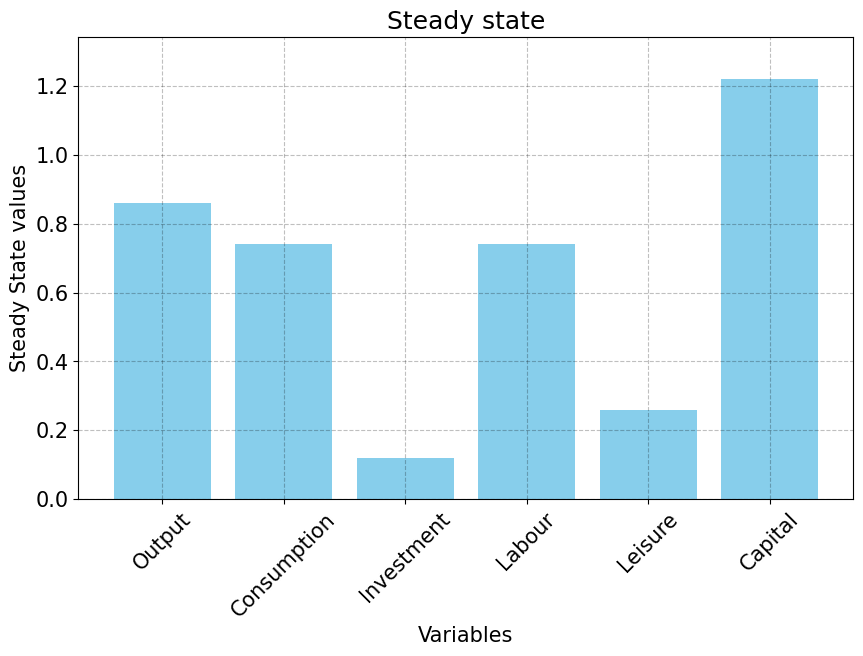

In [54]:
# 1. We create an instance of the class
simpleplot = SteadyStatePlotClass(variables, steady_state_values)

# 2. We plot the steady state values in a simple plot
simpleplot.simpleplot()

#### 11. <a id='interactiveplot'></a>[Interactive plot for the Steady State values](#interactiveplot)

To further analyze the numerical solution to the Real Business Cycle model, we make an interactive plot for the steady state values with different parameter values. Here, we will show how the steady state values change as a result of changes in the assumptions.

One reason for analyzing this is to assert if the steady values are sensitive or robust to changes in some of the parameters. Another reason for this analysis is to gain a deeper intuitive insight into the Real Business Cycle model, as we will get a visual idea of the theoretical relationships between the variables and parameters. Therefore, under the interactive plot, we will analyze the change of the parameters on the steady state values.
 
 In the interactive plot, it will be possible to change the values of the parameters by using one of the five sliders.

In [55]:
# Creating an instance the class
interactive_model = RBCModelInteractiveClass()
# Show the interactive plot
interactive_model.create_interactive_plot()

interactive(children=(FloatSlider(value=0.9, description='discount_rate', max=1.0, min=0.1), FloatSlider(value…

From the figure above, we can see how the steady state values change under different parameter values.
- **Discount rate ($\beta$)**: A higher discount rate will increase output, consumption, investment, and capital in the steady state.
- **Marginal disutility from labor ($\theta$)**: A higher marginal disutility from labor will first of all result in more leisure, as the households will prefer working less to have more leisure. The more leisure and thereby less labor will decrease output, consumption, investment, and capital.
- **Depreciation rate ($\delta$)**: A higher depreciation rate will decrease capital, output, consumption, leisure, and increase labor.
- **Capital share ($\alpha$)**: A higher capital share parameter will increase output, consumption, investment, leisure, capital, and decrease labor.
- **Technology ($A$)**: A higher technology parameter will increase output, consumption, investment, labor, capital, and decrease leisure.

### 12. <a id='extension'></a>[An extension of the model](#extension)

Our model extension involves replacing the Cobb-Douglas production function with a Constant Elasticity of Substitution (CES) function. 

CES production function:
\begin{equation}
    y_t = [\alpha k_t^{\rho} + (1 - \alpha )n_t^{\rho}]^{\frac{1}{\rho}}
\end{equation}

In [56]:
# 1. We redefine the parameters and variables by including 'rho'
parameters_CES = ['Discount rate', 'Disutility of labor', 'Depreciation rate', 'Capital share', 'Technology', 'rho']

# 2. Store the steady state values in a Pandas DataFrame
parameter_values_ces = pd.DataFrame({
    'name': parameters_CES,
    'value': [0.9, 3, 0.1, 1/3, 1, 0.5]
})

# 3. Create an instance of the class for maximizing the roots in the extended model
numericsolutionces = NumericalSolutionCESClass(parameter_values_ces['value'])

# 4. Store the steady state values for the extended model in a DataFrame
steady_state_values_CES = pd.DataFrame({
    'value': numericsolutionces.steady_state_numeric()
}, index=variables)

# 3. Round the number of decimals to be two
steady_state_values_CES['value'] = steady_state_values_CES['value'].round(2)

# 5. Show the steady state values for the extended model
print("The table for the steady state values for the variables can be seen below:")
steady_state_values_CES.T

The table for the steady state values for the variables can be seen below:


,Output,Consumption,Investment,Labour,Leisure,Capital
value,0.9,0.76,0.14,0.69,0.31,1.38


 We plot the steady state values in a static plot. 

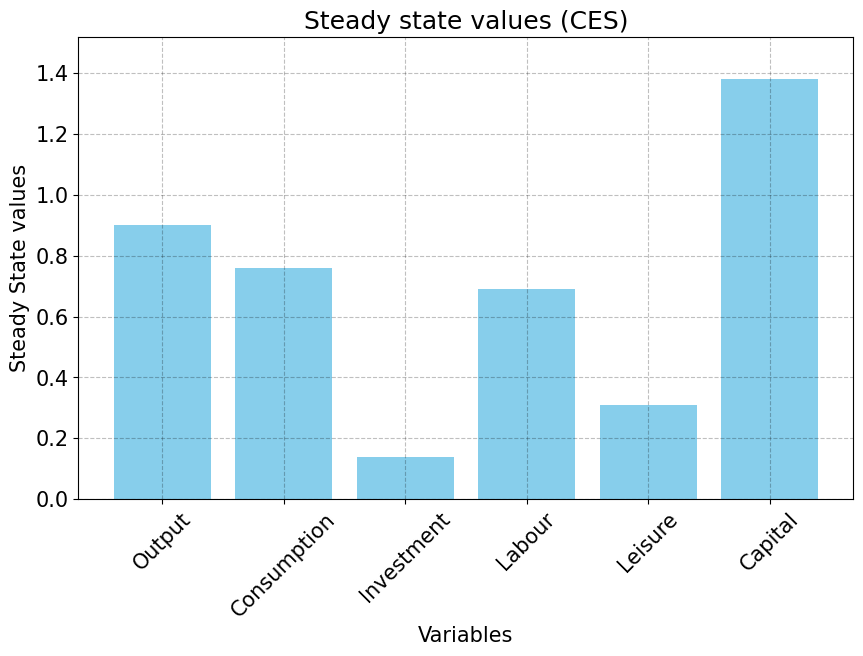

In [57]:
# Create an instance of SteadyStatePlotCES
plot_ces = SteadyStatePlotCESClass(variables, steady_state_values_CES)

# Plot the CES steady state values
plot_ces.simpleplot_ces()

Below, we compare the Steady State values for the variables in the RBC model with a CES production function and with a Cobb-Douglas:
- **Output ($Y$)**: Output is *higher* (0.9) with a CES production function compared to a Cobb-Douglas production function (0.86).
- **Consumption ($C$)**: Consumption is *higher* (0.76) with a CES production function compared a Cobb Douglas production function (0.74).
- **Investment ($I$)**: Investment is *higher* (0.14) with a CES production function compared to a Cobb-Douglass production function (0.12).
- **Labour ($n$)**: Labour is *lower* (0.69) with a CES production function compared to a Cobb-Douglas production function (0.74).
- **Leisure ($i$)**: Leisure is *higher* (0.31) with a CES production function compared to a Cobb-Douglas production function (0.26).
- **Capital ($K$)**: Capital is *higher* (1.22) with a CES production function compared to a Cobb-Douglas production function (1.22).

A reason for the higher steady state values except for labour could be due to the elasticity of substitution parameter in the CES production function. This is because, depending on this parameter, capital and labour can be substituted easier than in the Cobb-Douglass case. This higher flexibility could result in a more efficient allocation of the ressources, which makes the steady state values higher. 

# 13. <a id='conclusion'></a>[Conclusion](#conclusion)

The numerical analysis of the simple RBC model, using the Cobb-Douglas production function and its extension of the CES production function, shows that, generally, steady-state values are lower for the RBC model employing the Cobb-Douglas function compared to when the CES function is used, with labor being the exception.